# Import Library

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# SF

In [3]:
folder = 'SF'
file = 'SF_Skyline.csv'

In [4]:
path = Path('data/cities')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [5]:
path.ls

<bound method <lambda> of PosixPath('data/cities')>

# Download SF Images

In [6]:
classes = ['SF', 'NYC']

In [7]:
download_images(path/file, dest, max_pics=200)

Remove images that cannot be opened

In [8]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# NYC

In [9]:
folder = 'NYC'
file = 'Manhattan_Skyline.csv'

In [10]:
path = Path('data/cities')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [11]:
path.ls

<bound method <lambda> of PosixPath('data/cities')>

# Download SF Images

In [12]:
classes = ['SF', 'NYC']

In [13]:
download_images(path/file, dest, max_pics=200)

Remove images that cannot be opened

In [14]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# View data

In [15]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [16]:
data.classes

['NYC', 'SF']

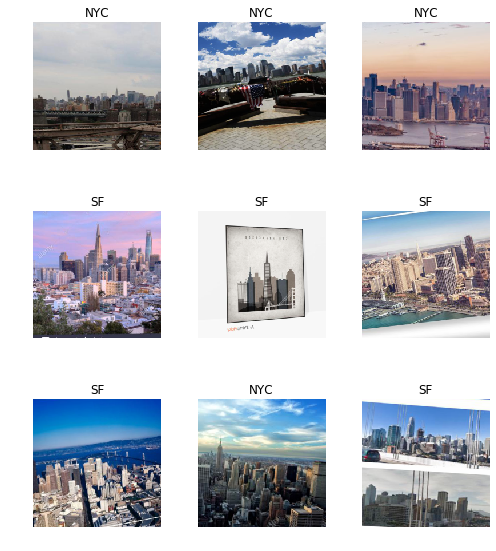

In [17]:
data.show_batch(rows=3, figsize=(7,8))

In [18]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['NYC', 'SF'], 2, 306, 76)

# Train Model

In [19]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.914729,0.828797,0.605263,00:04
1,0.765955,0.705169,0.394737,00:03
2,0.685443,0.645346,0.263158,00:03
3,0.610798,0.629941,0.250000,00:03


In [21]:
learn.save('stage-1')

In [22]:
learn.unfreeze()

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


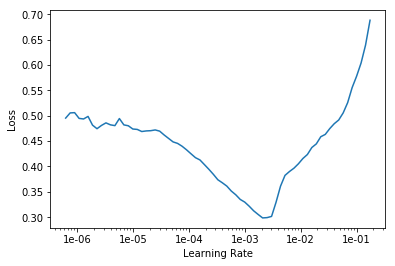

In [24]:
learn.recorder.plot()

In [25]:
# doc(learn.unfreeze)

In [26]:
learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.485357,0.503089,0.210526,00:03
1,0.382508,0.556194,0.210526,00:03
2,0.314219,0.537433,0.157895,00:03
3,0.261435,0.456601,0.144737,00:03


In [27]:
learn.save('stage-2')

In [28]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (306 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
SF,SF,SF,SF,SF
Path: data/cities;

Valid: LabelList (76 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NYC,NYC,NYC,NYC,SF
Path: data/cities;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): 

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

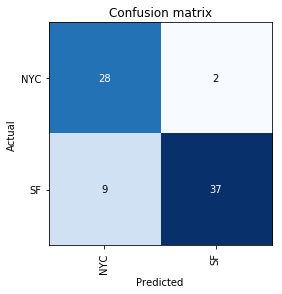

In [30]:
interp.plot_confusion_matrix()

# Clean Data

In [31]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [32]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [33]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [34]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

# Adjust Model

In [52]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (306 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
SF,SF,SF,SF,SF
Path: data/cities;

Valid: LabelList (76 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NYC,NYC,NYC,NYC,SF
Path: data/cities;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): 

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


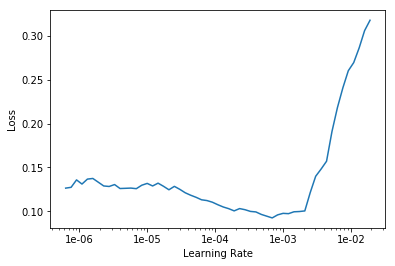

In [55]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(2, max_lr=slice(9e-5, 9e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.107711,0.381140,0.105263,00:03
1,0.074925,0.373204,0.092105,00:03


In [41]:
learn.save('stage-3')